# Preparing ARIA products for use in MintPy

Gareth Funning

This is a notebook that makes use of ARIA tools to download and prep ARIA standard product interferograms for use in MintPy.

## 1. Preliminaries 

(This all assumes that you have already installed ARIA tools. If not, get yourself to https://github.com/aria-tools/ARIA-tools and follow the instructions.)

First, check for data availability. You can go to https://search.asf.alaska.edu/ to see if the track/frame combination you are interested in has any data. Figure out the track number that you want to download data from. (I want data from track 35.) Also figure out what bounding box you want to find products for (south north west east). You can do this by drawing a rectangle on the ARIA products website, or by mousing around in Google Earth.

We'll start the Python with some dependencies and definitions that I borrowed from the tutorials (see https://github.com/aria-tools/ARIA-tools-docs):

In [3]:
import os
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable  

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.shapefile_util as shputil
except:
#     raise Exception('ARIA-tools is missing from your PYTHONPATH')
    pass
        
os.chdir(work_dir)


# this function allows easy plotting
def plot_layer(path_layer, lay_type=None, cmap=None, **kwargs):
    """ 
        path_layers is a string to the GDAL compatible dataset to be plotted
    """
    
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000 
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'): 
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=0
        vmax=1
        cmap='Greys'
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent,interpolation='nearest')
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

Work directory:  /mnt/c/Users/Gareth/Downloads
Tutorial directory:  /mnt/c/Users/Gareth/Downloads


## 2. Checking and downloading the available data

We can use the ariaDownload.py script to check for available data, and if we like what is there, to download it. 

In [ ]:
# let's see the options for the script
!ariaDownload.py

Next, you can use ariaDownload to check the numbers of interferograms available. Substitute in here your preferred Sentinel-1 track and bounding box ("south north west east"):

In [2]:
!ariaDownload.py --track 35 --bbox "38.6 39.0 -123.1 -122.5" -o count

/bin/bash: line 1: ariaDownload.py: command not found


And if you're happy, download them (with the correct track and box, as above):

In [ ]:
# this downloads the data for a given track and bounding box
!ariaDownload.py --track 35 --bbox "38.6 39.0 -123.1 -122.5" 

If your area of interest is covered by more than one frame, you will want to stitch them together. ARIA tools should do this for you. ariaExtract.py is the command that lets you look at these things... try and make sure that the minimum overlap area you specify is close to the area of your bounding box.

In [5]:
# some things to try here
!rm -f productBoundingBox/*.json        # clear out any existing bounding boxes
#!ariaExtract.py -f "products/*.nc" -nt 14  # no special conditions ('-nt 14' uses 14 CPU threads) 

!ariaExtract.py -f "products/*.nc" -mo 20000 -nt 4  # '-mo 20000' => area of minimum overlap in km^2

***Extract Product Function:***
Multi-core version
All (411) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (393) interferograms are spatially continuous.
No layers specified; only creating bounding box shapes
Thread count specified for gdal multiprocessing = 14


And this plots the bounding box you end up with that satisfies all your products:

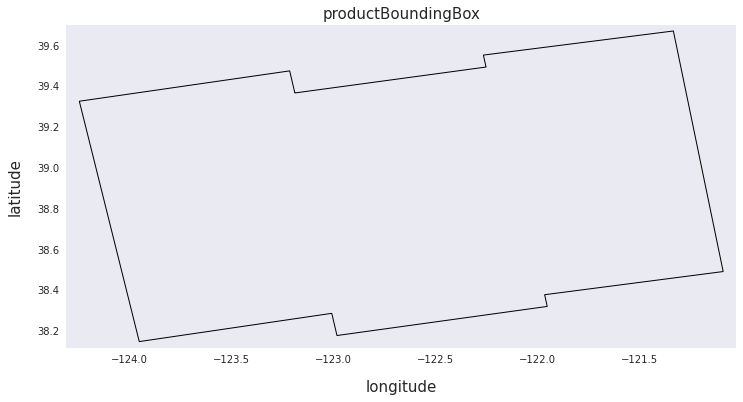

In [6]:
shputil.plot_shapefile(os.path.join('productBoundingBox', 'productBoundingBox.json'))

## 3. Preparing inputs for time series analysis with MintPy

If you like what you've been seeing above, you can move forward with the time series prep, using those same options, plus a couple more options that MintPy needs (downloading a DEM and water mask):

In [7]:
!ariaTSsetup.py -f 'products/*.nc' -mo 20000 -nt 4 -d Download --mask Download

***Time-series Preparation Function:***
Multi-core version
All (411) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (393) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 14
Download/cropping DEM
Downloaded 3 arc-sec SRTM DEM here: ./DEM/SRTM_3arcsec.dem
***Downloading water mask... ***

Extracting unwrapped phase, coherence, and connected components for each interferogram pair
Generating: unwrappedPhase - [>                        2%                       ] 20150921_20150828   27s /  1329sMulti-core version failed, will try single for loop
Generating: unwrappedPhase - [==================================================] 20200304_20200227  843s /    17s 
Generating: coherence - [==================================================] 20200304_20200227  265s /     5s 

Extracting single incidence angle, look angle and azimuth angle files valid over common interferometric grid
Genera